In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

from gpflow.config import default_float
from gpflow import set_trainable

from split_gplvm import SplitGPLVM
from utils import *

In [95]:
np.random.seed(1)

num_data = 200
dim = 5

xmin = 0
xmax = 10
break_pt = 3
k1 = 0.0
k21 = 0.3
k22 = -0.3
c1 = 0
sigma = 0.3
noise = 0
lengthscales = [0.25, 1, 1]

x = np.linspace(xmin, xmax, int(num_data/2), dtype=default_float())
X = branch_simulation(x, break_pt, k1, k21, k22, c1, sigma)
labels = np.repeat([0, 1], int(num_data)/2)
labels_dummy = pd.get_dummies(labels).values
Y = gen_obs(X, split_space=False, labels=labels, dim=dim, lengthscales=lengthscales, obs_noise=noise)

Text(0, 0.5, 'observed dimension 2')

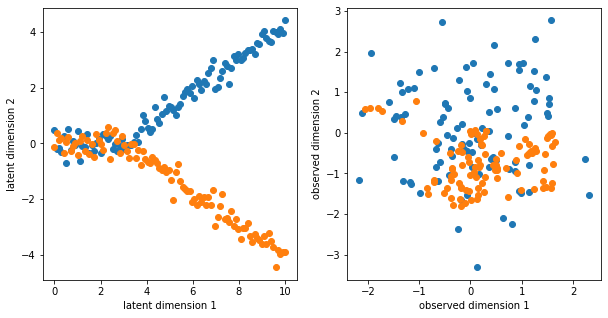

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in np.unique(labels):
    axs[0].scatter(x=X[labels == i, 0], y=X[labels == i, 1])
    axs[1].scatter(x=Y[labels == i, 0], y=Y[labels == i, 1])

axs[0].set_xlabel('latent dimension 1')
axs[0].set_ylabel('latent dimension 2')

axs[1].set_xlabel('observed dimension 1')
axs[1].set_ylabel('observed dimension 2')

In [99]:
# init pi w/ true labels, train pi, K = 2
m1 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    M=20,
    K=2,
    pi_init=tf.constant(labels_dummy + 1e-4, dtype=default_float())
)

# init pi w/ true labels, fixed pi, K = 2
m2 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    M=20,
    K=2,
    pi_init=tf.constant(labels_dummy + 1e-4, dtype=default_float())
)
set_trainable(m2.pi, False)

# init pi randomly, K = 1
m3 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    M=20,
    K=1
)

# init pi randomly, K = 1, have shared space
m4 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    Qs=1,
    M=20,
    K=1
)

# init pi randomly, K = 2, have shared space
m5 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    Qs=1,
    M=20,
    K=2
)

In [100]:
%%time
elbos = []
pis = []
models = [m1, m2, m3, m4, m5]
for i, m in enumerate(models):
    elbo, pi = train_natgrad_adam(m, 2000, 3000)
    elbos.append(elbo)
    pis.append(pi)
    print('finish model {}'.format(i))

initial elbo -257805.5811
finish model 0
initial elbo -1187941.2197
finish model 1
initial elbo -6538.2761
finish model 2
initial elbo -138046386.9151
finish model 3
initial elbo -425533195.8857
finish model 4
CPU times: user 21min 18s, sys: 7min 15s, total: 28min 33s
Wall time: 9min 5s


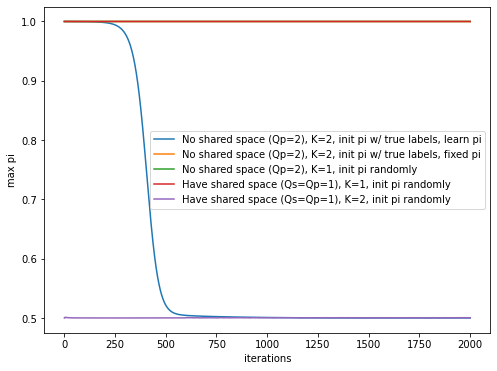

In [114]:
# save the max of assignment probabilities among all samples 
plt.figure(figsize=(8, 6))

for i, pi in enumerate(pis):
    maxpi = []
    for j in range(2000):
        maxpi.append(pi[j].numpy().max())
    x = np.arange(1, 2001)
    plt.plot(x, maxpi, label=names[i])
    
plt.xlabel('iterations')
plt.ylabel('max pi')
plt.legend()

Text(0, 0.5, 'ELBO')

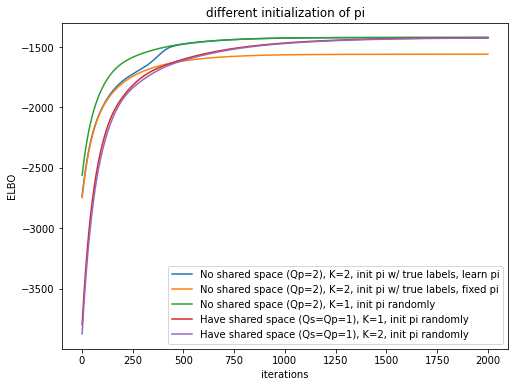

In [106]:
plt.figure(figsize=(8, 6))
x = np.arange(1, 2001)
names = [
    'No shared space (Qp=2), K=2, init pi w/ true labels, learn pi',
    'No shared space (Qp=2), K=2, init pi w/ true labels, fixed pi',
    'No shared space (Qp=2), K=1, init pi randomly',
    'Have shared space (Qs=Qp=1), K=1, init pi randomly',
    'Have shared space (Qs=Qp=1), K=2, init pi randomly'
]
for i, elbo in enumerate(elbos):
    plt.plot(x, elbo, label=names[i])
plt.legend()
plt.title('different initialization of pi')
plt.xlabel('iterations')
plt.ylabel('ELBO')

In [85]:
m2.kl_categorical(m2.pi, m2.pi_prior)

<tf.Tensor: shape=(), dtype=float64, numpy=138.42526713857745>

In [86]:
elbo1[-1] - elbo2[-1]

<tf.Tensor: shape=(), dtype=float64, numpy=138.4895290435968>

In [117]:
m5

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.009983642575197
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.02070151365452351
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.00109911]
SplitGPLVM.kernel_K[1].variance,Parameter,Softplus,,True,(),float64,0.02070151663046616
SplitGPLVM.kernel_K[1].lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.0010991]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 1)",float64,[[3.09855814e-05...
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 1)",float64,[[1.0068198...
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 2)",float64,"[[0.49999969, 0.50000031..."
SplitGPLVM.Zp.Z,Parameter,,,False,"(20, 1)",float64,[[0.64729624...
SplitGPLVM.q_mu,Parameter,,,False,"(20, 5)",float64,"[[0.04444481, -0.08683218, -0.04112471..."


Text(0.5, 1.0, 'By true x1')

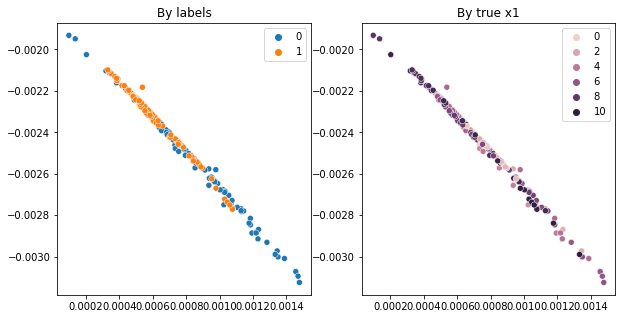

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
model = m4

sns.scatterplot(x=model.Xs_mean[:,0], y=model.Xp_mean[:,0], hue=labels, ax=axs[0])
axs[0].set_title('By labels')

sns.scatterplot(x=model.Xs_mean[:,0], y=model.Xp_mean[:,0], hue=X[:,0], ax=axs[1])
axs[1].set_title('By true x1')